### Import Library

In [1]:
import pandas as pd
import numpy as np

In [2]:
from src.PortfolioIndicator import PortfolioIndicator
from src.PortfolioConstructor import PortfolioConstructor

### Import Data

In [3]:
data_directory = "data/"
file = "all_cryptocurrency_price_data.csv"

In [4]:
df = pd.read_csv(data_directory+file)
df.index = pd.to_datetime(df.iloc[:,0])
df = df.iloc[:,1:]

### Check the number of asset available at each time stamp

In [5]:
df.shape

(1400, 299)

<AxesSubplot:xlabel='Unnamed: 0'>

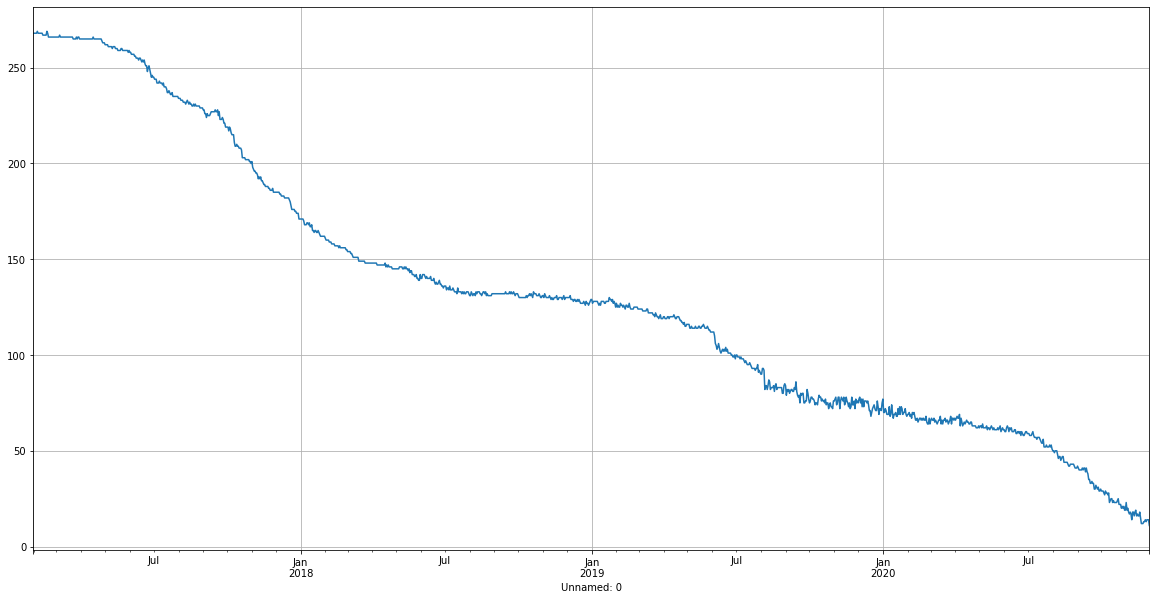

In [9]:
missing_value_date = df.isna().apply(sum,axis=1)
missing_value_date.plot(figsize=(20,10),grid=True)

### Select the Asset Universe

#### Select an initial date for which there are enough number of assets for testing

In [11]:
initial_date = "2019-01-01"

In [12]:
sub_df = df[df.index > initial_date]
sub_df = sub_df.fillna(method="ffill")
complete_sub_df = sub_df.dropna(axis=1)

#### Create Two universe based on the price

In [15]:
small_threshold = 10
big_threshold = 1

In [16]:
small_complete_df = complete_sub_df.iloc[:,list((complete_sub_df.iloc[0,:]<small_threshold))]

In [17]:
big_complete_df = complete_sub_df.iloc[:,list((complete_sub_df.iloc[0,:]>big_threshold))]

In [18]:
complete_sub_df.shape

(699, 172)

In [20]:
small_complete_df.shape

(699, 160)

In [21]:
big_complete_df.shape

(699, 39)

### Momentum Strategy Test

In [22]:
universe_df = complete_sub_df

#### Calculate the Signal

Define the parameter for the strategy.
1. momentum_period : the number of days to look back
2. waiting_period : number of days to wait before make a transaction

In [24]:
momentum_period = 3
waiting_time = 1

This steps calculate the return of the asset between the close of the current day and the close of the looking back day

In [27]:
temp_df = universe_df.pct_change(periods=momentum_period)

Because we get this signal at the end of the day, so we can not execute transaction on that day. 

We have to wait for another day to execute transaction. So we shift the signal one day forward .

For example: for VIBE, the first signal is obtained at the end of Jan.5th. 

This signal is used to determine transaction on the Jan.6th.

So we shift the signal one day forward to represent the fact that we use this signal on Jan.6th.

In [29]:
temp_df = temp_df.shift(1)

We then drop the missing value from the dataset.

In [30]:
temp_df = temp_df.dropna()

We could achieve previous steps in an aggregate command.

In [31]:
complete_ret_sub_df = universe_df.pct_change(periods=momentum_period).shift(waiting_time).dropna()

### Portfolio Construciton

#### Reframe the dataset

To use the portfolio construction class, we have to reshape the dataset to a long panel dataset.

In [32]:
complete_ret_sub_df_long = complete_ret_sub_df.stack()

In [36]:
signal_df = complete_ret_sub_df_long.index.to_frame()
signal_df.index = range(0,signal_df.shape[0])
signal_df["momentum"] = list(complete_ret_sub_df_long)
signal_df.columns=["date","ticker","momentum"]

#### Create Portfolio Indicator

We firstly need to create a  portfolio indicator series which indicates which portfolio the asset belongs to at certain date.


This can be achieved by using the class PortfolioIndicator

This class requires a list of rebalance date, a dataframe that contains the signal, the name of the signal, and the number of portfolios.










Here, we choose a daily rebalance strategy. 

At the end of each day, we rebalance the strategy.

We create 5 portfolio using equal weighted method.



In [37]:
rebalance_date_series = list(complete_ret_sub_df.index)

In [38]:
portfolio_indicator = PortfolioIndicator()

In [39]:
portfolio_indicator = portfolio_indicator.create_indicator(signal_df,"momentum",rebalance_date_series,5)

#### Example of Portfolio

Example Date : 2019-01-06

In [42]:
sub_df = portfolio_indicator[portfolio_indicator.date=="2019-01-06"]

In [45]:
top_portfolio = sub_df["ticker"][sub_df["momentum_indicator"]==4]
bottom_portfolio = sub_df["ticker"][sub_df["momentum_indicator"]==0]

Check the signal 

In [55]:
top_signal = complete_ret_sub_df[list(top_portfolio)].iloc[0,:]

In [56]:
bottom_signal = complete_ret_sub_df[list(bottom_portfolio)].iloc[0,:]

In [59]:
top_signal.mean()

0.08376442369676143

In [58]:
bottom_signal.mean()

-0.07123180492364492

In [60]:
top_signal.median()

0.04157317681090511

In [61]:
bottom_signal.median()

-0.060040502144995234

In [78]:
complete_ret_sub_df.index[0]

Timestamp('2019-01-06 00:00:00+0000', tz='UTC')

Check the return

In [72]:
complete_sub_df_1_day_return = universe_df.pct_change().dropna()

In [81]:
complete_sub_df_1_day_return

,VIBE,BCD,NAS,VET,BCH,CTXC,ONTGAS,POA,BLZ,PPT,...,VIB,NPXS,EVX,MCO,CND,TRX,ELF,DCR,BTC,STORJ
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2019-01-03 00:00:00+00:00,-0.020507,-0.040837,-0.056507,-0.056983,-0.062782,-0.038608,-0.013490,-0.030269,-0.044713,-0.056224,...,-0.021548,-0.037124,-2.779740e-02,-0.018832,-0.021314,0.003068,-0.010352,-0.017922,-0.034209,-0.020033
2019-01-04 00:00:00+00:00,0.086113,0.001981,0.012124,0.019035,-0.001719,0.025790,-0.048615,0.047155,0.063915,0.006464,...,0.035140,0.042470,6.002643e-02,0.020526,0.033073,0.037731,0.032105,0.024468,0.013710,0.007449
2019-01-05 00:00:00+00:00,0.078887,0.020718,-0.000034,-0.004472,-0.002309,0.003956,0.000799,-0.011276,-0.021437,0.025413,...,-0.016475,-0.018449,-3.325640e-02,0.103294,0.005732,0.083543,-0.019060,-0.004662,-0.008939,0.012950
2019-01-06 00:00:00+00:00,0.011818,0.049254,0.037042,0.072453,0.038697,0.284719,-0.021715,0.054478,0.068612,0.052967,...,0.058857,0.069522,5.310210e-02,0.034963,0.112359,0.028707,0.060217,0.063627,0.061779,0.043191
2019-01-07 00:00:00+00:00,-0.032628,-0.040117,-0.008068,-0.043537,-0.032439,-0.063994,0.044851,-0.013696,-0.056020,-0.022435,...,-0.000881,-0.042157,-4.857734e-02,0.003455,-0.062356,0.006384,-0.043233,-0.032837,-0.013898,0.006554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26 00:00:00+00:00,-0.166528,-0.096881,-0.133012,-0.121914,-0.131998,-0.114979,-0.300576,-0.169641,-0.156842,-0.116152,...,-0.142409,-0.092958,-1.130802e-01,-0.220452,-0.115270,-0.107583,-0.130237,0.003042,-0.084293,-0.152022
2020-11-27 00:00:00+00:00,0.009187,0.002786,-0.028221,-0.007197,-0.021959,-0.015132,-0.066878,0.006794,-0.032403,0.016241,...,-0.003020,0.002642,8.473809e-07,0.091717,-0.022005,-0.005642,0.040591,0.046715,-0.001834,-0.024698
2020-11-28 00:00:00+00:00,0.057147,0.026345,0.017922,0.059476,0.039945,0.028998,0.254622,0.034277,-0.002837,0.057838,...,0.049396,0.000000,3.219404e-02,-0.055379,0.013835,0.034145,0.027586,-0.002154,0.032988,0.032203


In [82]:
top_return = complete_sub_df_1_day_return.loc[complete_ret_sub_df.index[0],list(top_portfolio)]
bottom_return = complete_sub_df_1_day_return.loc[complete_ret_sub_df.index[0],list(bottom_portfolio)]

In [83]:
top_return.mean()

0.037827320639233504

In [84]:
bottom_return.mean()

0.05399171009955972

In [87]:
top_return.median()

0.034468753751165426

In [88]:
bottom_return.median()

0.05816611578945685

### Calculate Portfolio Strategy Return

#### Prepare the daily return dataset for each asset

In [93]:
complete_sub_df_1 = universe_df.pct_change().dropna()
complete_sub_df_1_long = complete_sub_df_1.stack()

In [94]:
index_df = complete_sub_df_1_long.index.to_frame()
index_df["ret"] = complete_sub_df_1_long
index_df.index=range(0,index_df.shape[0])
index_df.columns = ["date","ticker","ret"]

In [95]:
return_df = index_df

#### Merge the return and indicator 

In [101]:
merge_df = return_df.merge(portfolio_indicator,on=["date","ticker"])

In [103]:
merge_df.head()

,date,ticker,ret,momentum_indicator,year,month,day
0,2019-01-06 00:00:00+00:00,VIBE,0.011818,4,2019,1,6
1,2019-01-06 00:00:00+00:00,BCD,0.049254,2,2019,1,6
2,2019-01-06 00:00:00+00:00,NAS,0.037042,1,2019,1,6
3,2019-01-06 00:00:00+00:00,VET,0.072453,1,2019,1,6
4,2019-01-06 00:00:00+00:00,BCH,0.038697,0,2019,1,6


#### Calculate strategy return

Initialize the portfolio return calculation class.

The initialization of this class requires a dataframe.

The dataframe should contain at least three columns.

1. Date
2. Ticker
3. Return
4. Portfolio Indicator

In [104]:
portfolio_constructor = PortfolioConstructor(merge_df)

In [105]:
strategy_ret_df = portfolio_constructor.create_portfolio_series("momentum_indicator",equal_weight=True)

#### Evaluate the performance of the strategy

In [106]:
strategy_ret_df.describe()

momentum_indicator,0,1,2,3,4
count,695.000000,695.000000,695.000000,695.000000,695.000000
mean,0.009986,0.004265,0.003353,0.001372,-0.002481
std,0.064708,0.042579,0.041150,0.041468,0.044252
min,-0.436143,-0.457676,-0.397719,-0.437534,-0.432827
25%,-0.013008,-0.012471,-0.014100,-0.016217,-0.023237
50%,0.010476,0.008147,0.005998,0.003844,-0.001627
75%,0.026845,0.023658,0.023381,0.021421,0.019886
max,0.897101,0.253012,0.234573,0.181730,0.342247


<AxesSubplot:ylabel='Density'>

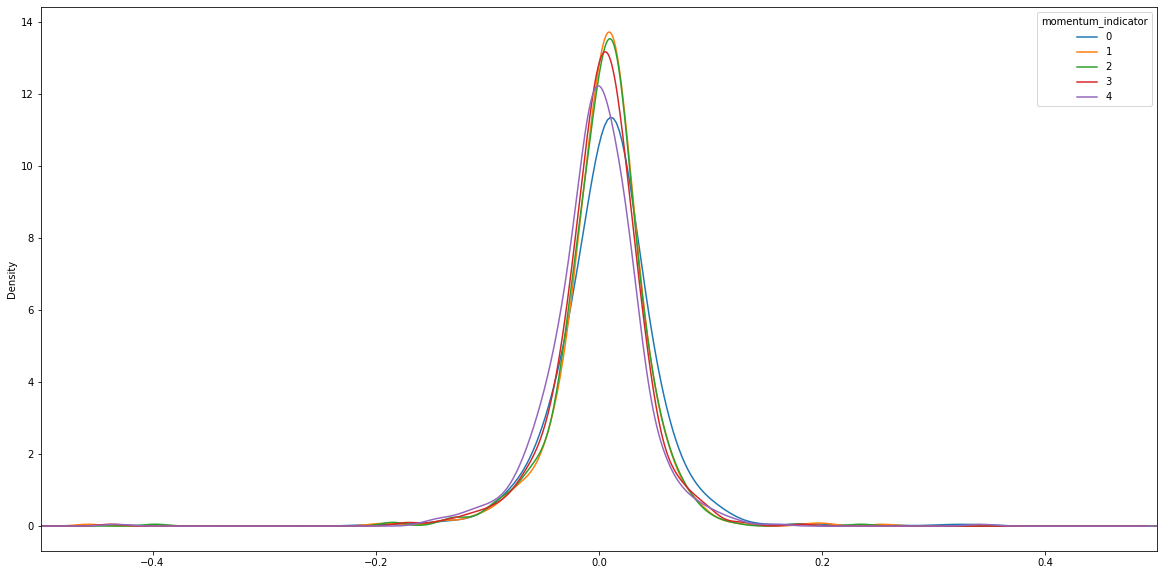

In [112]:
strategy_ret_df.plot(kind="density",figsize=(20,10),xlim=(-0.5,0.5))

In [113]:
strategy_cum_ret_df = (strategy_ret_df+1).cumprod()

<AxesSubplot:xlabel='date'>

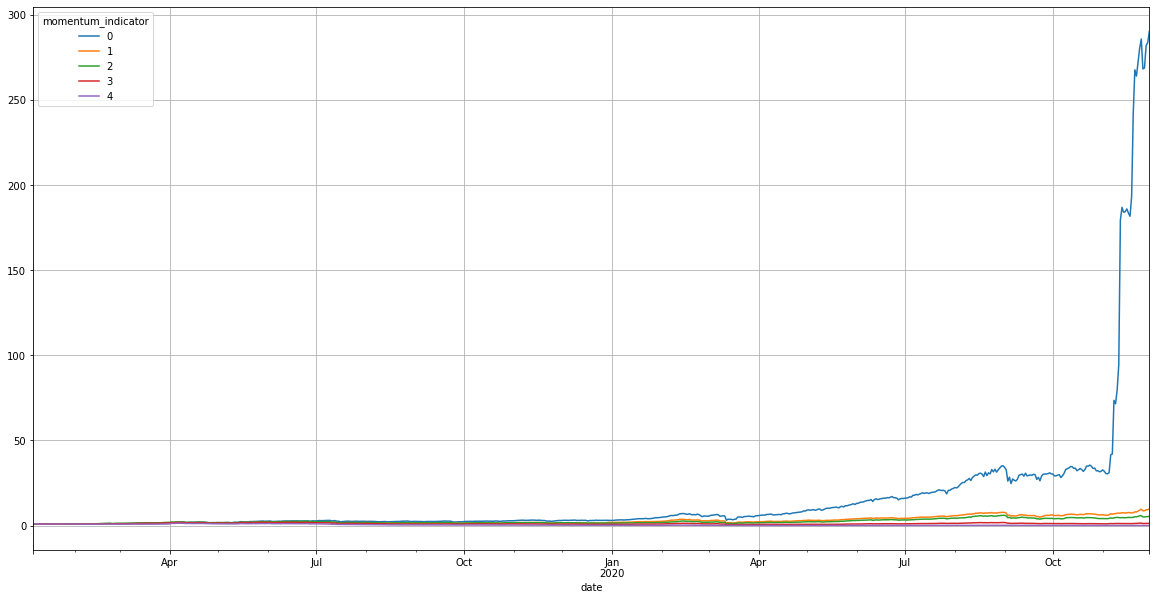

In [115]:
strategy_cum_ret_df.iloc[0:,:].plot(figsize=(20,10),grid=True)

<AxesSubplot:xlabel='date'>

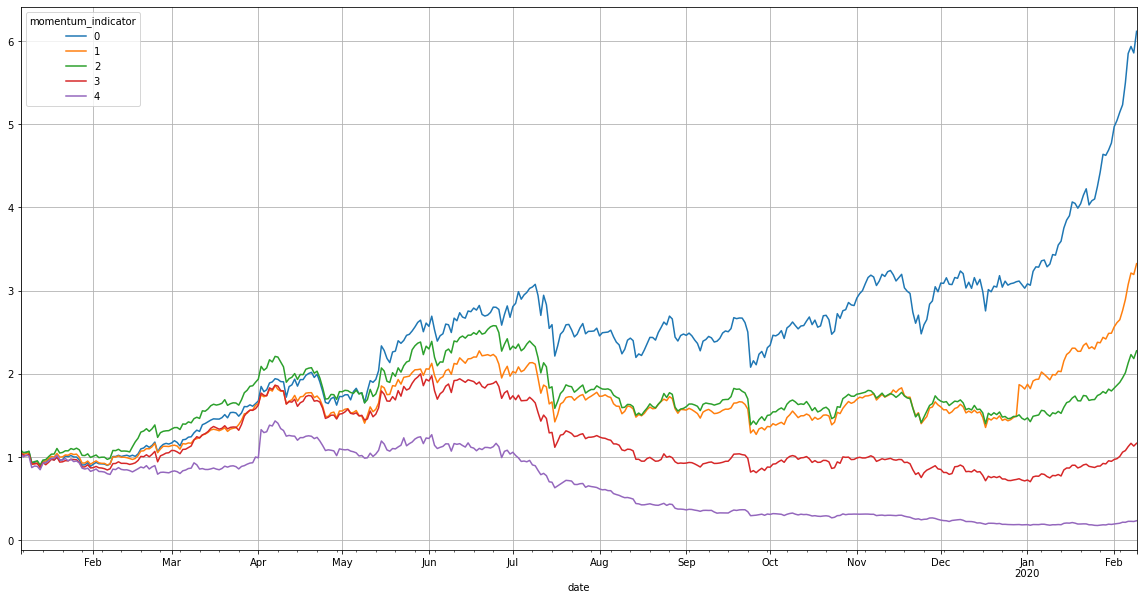

In [116]:
strategy_cum_ret_df.iloc[0:400,:].plot(figsize=(20,10),grid=True)

In [423]:
strategy_ret_df.mean()/strategy_ret_df.std()

momentum_indicator
0    0.070985
1    0.030153
2    0.065055
3    0.064430
4    0.064429
dtype: float64

Create a Long Short Strategy

In [124]:
long_short_return = strategy_ret_df.iloc[:,0] - strategy_ret_df.iloc[:,4]

In [125]:
long_short_return.mean()

0.012467312741143738

In [128]:
long_short_return.median()

0.010140942426106948

In [126]:
long_short_return.mean()/long_short_return.std()

0.23840503232792798

In [127]:
long_short_return.median()

0.010140942426106948

In [131]:
factor_return = (long_short_return+1).cumprod()

<AxesSubplot:xlabel='date'>

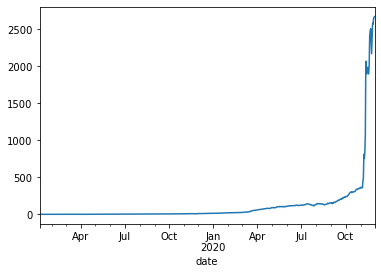

In [132]:
factor_return.plot()